In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pybullet as p
import pybullet_data
import time
import numpy as np

from robot_golf.env.prefix import GRAVITY, BALL_COLLISION_RADIUS
from robot_golf.env.ball import ball_aerodynamics
from robot_golf.planner.robot import get_club_init_transform
from robot_golf.simulator import set_simulator

from sys_id import prepare, generate_data

pybullet build time: May 20 2022 19:44:17


In [3]:
def collect_data():
    ball_pos = np.array([0.0, -0.5, 0.35])
    robot_id, joint_pos, ball_id, v_ball_init = prepare(ball_pos)

    # generate_data
    qdot_1 = np.random.normal(-50, 5)
    qdot_2 = np.random.normal(-7, 8)
    v_ball_real = generate_data(robot_id, joint_pos, ball_id, qdot_1, qdot_2)
    # p.disconnect()
    return [qdot_1, qdot_2], v_ball_real

In [4]:
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [5]:
qdots = np.zeros((0, 2))
vs = np.zeros((0, 3))

In [6]:
for j in range(1, 201):
    try:
        qdot, v = collect_data()
        qdots = np.concatenate((qdots, np.array(qdot).reshape(1, -1)), axis=0)
        vs = np.concatenate((vs, np.array(v).reshape(1, -1)), axis=0)
        print(f'{qdots.shape[0]}, v_ball_real: {v}')
    except:
        pass
    p.resetSimulation()
    # if j%200==0:
invalid_idx = []
for i in range(vs.shape[0]):
    if vs[i, 0] == None or vs[i, 2] < 5:
        invalid_idx.append(i)
valid_qdots = np.delete(qdots, invalid_idx, axis=0)
valid_vs = np.delete(vs, invalid_idx, axis=0)
np.save(f'qdots_val.npy', valid_qdots)
np.save(f'vs_val.npy', valid_vs)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
world_linkb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_link_0
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be

In [10]:
invalid_idx = []
for i in range(vs.shape[0]):
    if vs[i, 0] == None or vs[i, 2] < 5:
        invalid_idx.append(i)
print(invalid_idx)

[0, 5, 6, 7, 13, 22, 36, 41, 42, 45, 46, 47, 48, 49, 52, 56, 58, 63, 73, 74, 79, 86, 87, 93, 96]


In [11]:
valid_qdots = np.delete(qdots, invalid_idx, axis=0)
valid_vs = np.delete(vs, invalid_idx, axis=0)

In [12]:
valid_qdots.shape

(75, 2)

True


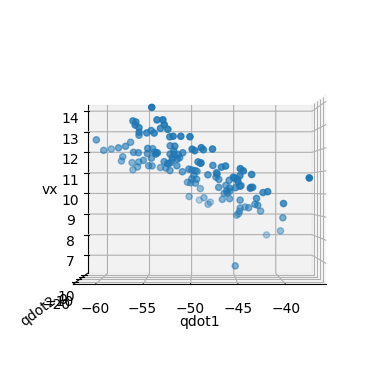

In [11]:
# fig = plt.figure()
# ax = mplot3d.Axes3D(fig)
%matplotlib inline
ax = plt.axes(projection='3d')

plot_geeks = ax.scatter(valid_qdots[:,0], valid_qdots[:,1], valid_vs[:,2])
ax.set_xlabel('qdot1')
ax.set_ylabel('qdot2')
ax.set_zlabel('vx')
ax.view_init(elev=0, azim=-90)

print(plt.isinteractive())
plt.show()

### Fitting

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [11]:
input_all = valid_vs.copy()
output_x = valid_qdots[:,0]
output_y = valid_qdots[:,1]

#### second-order polynomial

In [12]:
poly_second_order = PolynomialFeatures(degree=2)
input_second_order = poly_second_order.fit_transform(input_all)

clf_second_order_x = linear_model.LinearRegression()
clf_second_order_x.fit(input_second_order, output_x)
clf_second_order_y = linear_model.LinearRegression()
clf_second_order_y.fit(input_second_order, output_y)

LinearRegression()

In [69]:
dir(clf_second_order_x)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 '_validate_params',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_features_in_',
 'n_jobs',
 'positive',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

In [77]:
print(clf_second_order_x.coef_)
print(clf_second_order_y.coef_)

[ 0.          1.09470062  5.92428558  3.11208748 -0.34473883 -0.41970851
  0.02019625  0.37260651 -0.12307135 -0.23749958]
[ 0.          4.10949569 -7.64972368  3.16672815 -0.35112686  0.82761246
 -0.32129703 -1.81880136  0.62503639 -0.1596113 ]


In [23]:
np.save('qdots.npy', valid_qdots)
np.save('vs.npy', valid_vs)

In [83]:
clf_second_order_x.get_params(deep=True)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [13]:
check_second_x = (clf_second_order_x.predict(input_second_order)-output_x)/np.var(output_x)
check_second_y = (clf_second_order_y.predict(input_second_order)-output_y)/np.var(output_y)

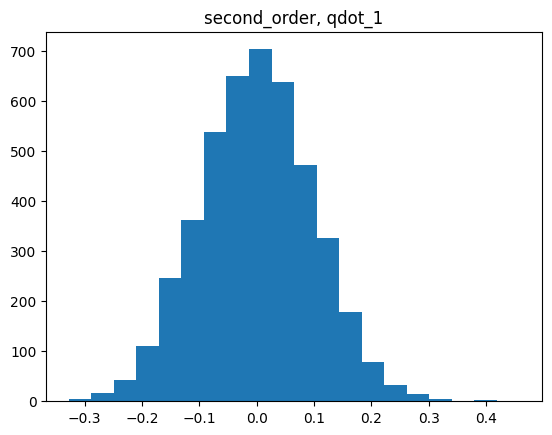

In [14]:
%matplotlib inline
plt.hist(check_second_x, 20)
plt.title('second_order, qdot_1')
plt.show()

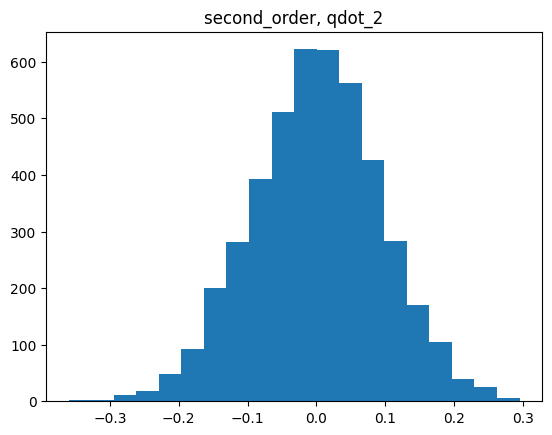

In [15]:
%matplotlib inline
plt.hist(check_second_y, 20)
plt.title('second_order, qdot_2')
plt.show()

#### third-order polynomial

In [20]:
poly_third_order = PolynomialFeatures(degree=5)
input_third_order = poly_third_order.fit_transform(input_all)

clf_third_order_x = linear_model.LinearRegression()
clf_third_order_x.fit(input_third_order, output_x)
clf_third_order_y = linear_model.LinearRegression()
clf_third_order_y.fit(input_third_order, output_y)

LinearRegression()

In [21]:
check_third_x = (clf_third_order_x.predict(input_third_order)-output_x)/np.var(output_x)
check_third_y = (clf_third_order_y.predict(input_third_order)-output_y)/np.var(output_y)

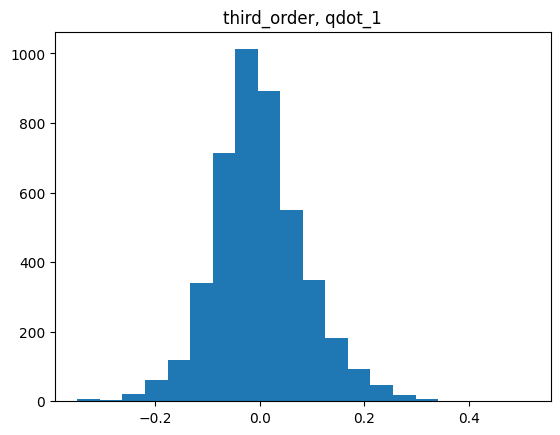

In [22]:
%matplotlib inline
plt.hist(check_third_x, 20)
plt.title('third_order, qdot_1')
plt.show()

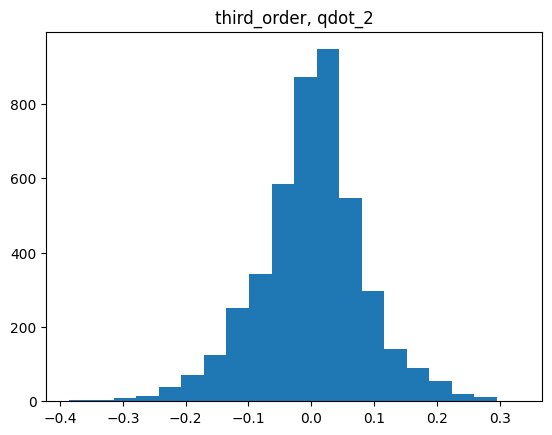

In [23]:
%matplotlib inline
plt.hist(check_third_y, 20)
plt.title('third_order, qdot_2')
plt.show()